# Template matching with a multiple templates

Templates are selected from Weiqiang Zhu's PhaseNet catalog.

This notebook is the continuation of the first notebook, `tm_one_template.ipynb`.

--------------------------------------------------------------------

Download the seismic data at: https://doi.org/10.5281/zenodo.15097180

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15097180.svg)](https://doi.org/10.5281/zenodo.15097180)


Download the PhaseNet earthquake catalog with the following three commands:
- curl -o adloc_events.csv https://storage.googleapis.com/quakeflow_share/Ridgecrest/adloc/adloc_events.csv
- curl -o adloc_picks.csv https://storage.googleapis.com/quakeflow_share/Ridgecrest/adloc/adloc_picks.csv
- curl -o adloc_stations.csv https://storage.googleapis.com/quakeflow_share/Ridgecrest/adloc/adloc_stations.csv

In [499]:
import os
import fast_matched_filter as fmf
import glob
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import pandas as pd


In [500]:
# path variables and file names
DIR_WAVEFORMS = "/home/ebeauce/SSA_EQ_DETECTION_WORKSHOP/data" # REPLACE THIS PATH WITH WHEREVER YOU DOWNLOADED THE DATA
DIR_CATALOG = "../picks_phasenet/"

STATION_FILE = "adloc_stations.csv"
EVENT_FILE = "adloc_events.csv"
PICK_FILE = "adloc_picks.csv"

## Load PhaseNet catalog

Here, we read the catalog of the 2019 Ridgecrest sequence made with PhaseNet. Information is divided into three files:
- a station metadata file,
- an event metadata file (the catalog per se),
- a pick database, which contains all the P- and S-wave picks found by PhaseNet.

In [501]:
station_meta = pd.read_csv(os.path.join(DIR_CATALOG, STATION_FILE))

The following shows a very rudimentary map of the station network. Look into the `cartopy` package for more sophisticated maps.

Text(0.5, 1.0, 'Stations used to build the PhaseNet catalog')

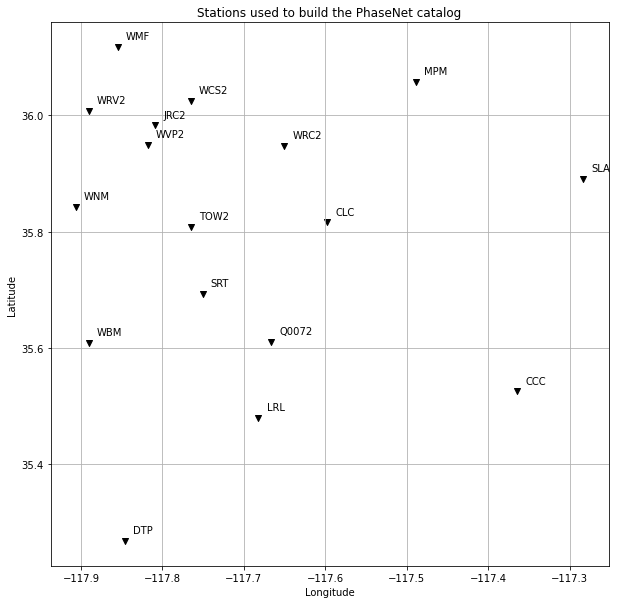

In [502]:
_station_meta = station_meta.drop_duplicates("station")

fig, ax = plt.subplots(num="station_network", figsize=(10, 10))
ax.scatter(_station_meta["longitude"], _station_meta["latitude"], marker="v", color="k")
for idx, row in _station_meta.iterrows():
    ax.text(row.longitude + 0.01, row.latitude + 0.01, row.station, va="bottom", ha="left")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid()
ax.set_title("Stations used to build the PhaseNet catalog")

In [503]:
event_meta = pd.read_csv(os.path.join(DIR_CATALOG, EVENT_FILE))
event_meta["time"] = pd.to_datetime(event_meta["time"])

In [504]:
picks = pd.read_csv(os.path.join(DIR_CATALOG, PICK_FILE))

## Read continuous seismograms from 2019-07-04

In [505]:
def fetch_day_waveforms(dir_waveforms):
    """
    Fetches the continuous seismograms for a given day.

    Parameters
    ----------
    dir_waveforms : str
        Directory where the waveform data is stored, by default DIR_WAVEFORMS.

    Returns
    -------
    obspy.Stream
        Stream object containing the fetched continuous seismograms.
    """
    stream = obs.Stream()
    files = glob.glob(os.path.join(dir_waveforms, "*mseed"))
    for _file in files:
        stream += obs.read(_file)
    return stream

In [506]:
# first, read the continuous seismograms into an `obspy.Stream`
continuous_seismograms = fetch_day_waveforms(DIR_WAVEFORMS)
print(continuous_seismograms.__str__(extended=True))

57 Trace(s) in Stream:
CI.WCS2..HHE | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
PB.B916..EHZ | 2019-07-03T23:59:59.998200Z - 2019-07-04T23:59:59.958200Z | 25.0 Hz, 2160000 samples
CI.CLC..HHN  | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.WRV2..EHZ | 2019-07-04T00:00:00.000000Z - 2019-07-04T23:59:59.960000Z | 25.0 Hz, 2160000 samples
PB.B916..EH2 | 2019-07-03T23:59:59.998200Z - 2019-07-04T23:59:59.958200Z | 25.0 Hz, 2160000 samples
PB.B917..EH1 | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.WMF..HHZ  | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
PB.B918..EHZ | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
PB.B918..EH2 | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.TOW2..HHZ | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25

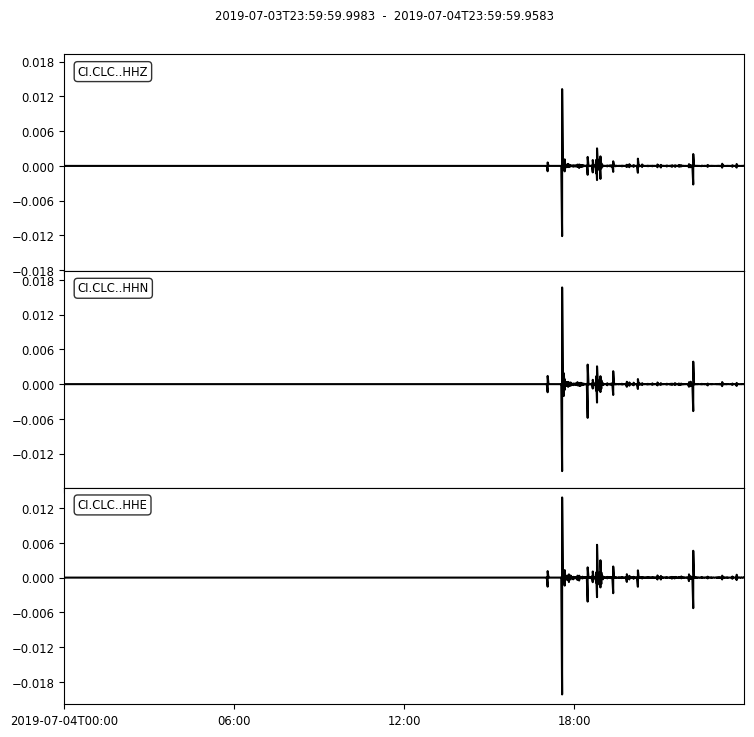

In [507]:
# plot the continuous seismograms from a single station
fig = continuous_seismograms.select(station="CLC").plot()

In [508]:
# then, cast data into `numpy.ndarray`
station_codes = list(set([st.stats.station for st in continuous_seismograms]))
component_codes = ["N", "E", "Z"]
component_aliases={"E": ["E", "2"], "N": ["N", "1"], "Z": ["Z"]}

num_stations = len(station_codes)
num_channels = len(component_codes)
num_samples = len(continuous_seismograms[0].data)

continuous_seismograms_arr = np.zeros((num_stations, num_channels, num_samples), dtype=np.float32)
for s, sta in enumerate(station_codes):
    for c, cp in enumerate(component_codes):
        for cp_alias in component_aliases[cp]:
            sel_seismogram = continuous_seismograms.select(station=sta, component=cp_alias)
            if len(sel_seismogram) > 0:
                continuous_seismograms_arr[s, c, :] = sel_seismogram[0].data
                break
            
continuous_seismograms_arr


array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.29586064e-10, -8.54010890e-11, -1.54528432e-10, ...,
         -1.52945837e-10, -4.11596229e-10, -2.50905463e-10]],

       [[ 2.37386014e-11,  1.53665813e-11, -3.40902896e-11, ...,
         -6.43728626e-10,  2.97708330e-10,  4.56077842e-10],
        [-2.53759392e-11, -4.20401144e-11, -6.94136068e-11, ...,
          2.63994826e-09, -1.96964622e-09, -2.60437849e-09],
        [-7.44370451e-12, -5.62608536e-11, -1.99733771e-11, ...,
          1.09469663e-10,  4.91648389e-10, -2.35225506e-10]],

       [[-2.17876342e-10,  6.85961843e-10,  7.17887916e-10, ...,
          1.70164771e-10, -1.17840571e-10,  7.70367548e-10],
        [-4.97894448e-10,  1.05527857e-10,  2.88735202e-10, ...,
          1.23880373e-09,  5.19077503e-10,  1.027

## Build template database 

Using the PhaseNet catalog, we will select all events with magnitudes between 3 and 5 as template events (totally arbitrary choice!).

In [509]:
def fetch_event_waveforms(
    event_picks,
    folder="preprocessed_2_12",
    dir_waveforms=DIR_WAVEFORMS,
    time_before_phase_onset_sec=2.0,
    duration_sec=10.0
    ):
    """
    Fetches the waveforms for a given event based on the picks.

    Parameters
    ----------
    event_picks : pandas.DataFrame
        DataFrame containing the picks for the event.
    folder : str, optional
        Folder name where the preprocessed waveforms are stored, by default "preprocessed_2_12".
    dir_waveforms : str, optional
        Directory where the waveform data is stored, by default DIR_WAVEFORMS.
    time_before_phase_onset_sec : float, optional
        Time in seconds to start the waveform before the phase onset, by default 2.0.
    duration_sec : float, optional
        Duration in seconds of the waveform to fetch, by default 10.0.

    Returns
    -------
    obspy.Stream
        Stream object containing the fetched waveforms.
    """
    date = pd.Timestamp(event_picks.iloc[0]["phase_time"]).strftime("%Y-%m-%d")
    # full path to waveform directory for this given day
    dir_data = os.path.join(dir_waveforms, date.replace("-", ""), folder)
    stream = obs.Stream()
    for _, pick in event_picks.iterrows():
        # check whether we have a miniseed file for this waveform
        if pick.phase_type == "P":
            files = glob.glob(os.path.join(dir_data, pick.station_id + "Z*mseed"))
        elif pick.phase_type == "S":
            files = glob.glob(os.path.join(dir_data, pick.station_id + "[N,E]*mseed"))
        starttime = obs.UTCDateTime(pick.phase_time) - time_before_phase_onset_sec
        endtime = starttime + duration_sec
        for _file in files:
            stream += obs.read(
                _file,
                starttime=starttime,
                endtime=endtime
            )
    return stream

def two_point_distance(lon_1, lat_1, depth_1, lon_2, lat_2, depth_2):
    """Compute the distance between two points.


    Parameters
    -----------
    lon_1: scalar, float
        Longitude of Point 1.
    lat_1: scalar, float
        Latitude of Point 1.
    depth_1: scalar, float
        Depth of Point 1 (in km).
    lon_2: scalar, float
        Longitude of Point 2.
    lat_2: scalar, float
        Latitude of Point 2.
    depth_2: scalar, float
        Depth of Point 2 (in km).

    Returns
    ---------
    dist: scalar, float
        Distance between Point 1 and Point 2 in kilometers.
    """

    from obspy.geodetics.base import calc_vincenty_inverse

    dist, az, baz = calc_vincenty_inverse(lat_1, lon_1, lat_2, lon_2)
    dist /= 1000.0  # from m to km
    dist = np.sqrt(dist**2 + (depth_1 - depth_2) ** 2)
    return dist
    

In [510]:
# select events based on magnitude and origin time

# comprehensive run with lots of templates:
selected_events_meta = event_meta[
    (
        (event_meta["time"] >= "2019-07-04")
        & (event_meta["time"] < "2019-07-04T15:00:00")
    )
    | (
        (event_meta["magnitude"] > 1.0)
        & (event_meta["magnitude"] < 5.0)
        & (event_meta["time"] >= "2019-07-04")
        & (event_meta["time"] < "2019-07-04T23:50:00")
    )
    ]
num_templates = len(selected_events_meta)

# quick test:
# selected_events_meta = event_meta[
#     (event_meta["magnitude"] > 3.0)
#     & (event_meta["magnitude"] < 5.0)
#     & (event_meta["time"] >= "2019-07-04")
#     & (event_meta["time"] < "2019-07-04T23:50:00")
#     ]
# num_templates = len(selected_events_meta)

selected_events_meta

,time,adloc_score,adloc_residual_time,num_picks,magnitude,adloc_residual_amplitude,event_index,longitude,latitude,depth_km
0,2019-07-04 00:46:47.342963596,0.866596,0.057355,35,0.595368,0.165480,6720,-117.882570,36.091088,4.643969
1,2019-07-04 00:55:32.648412579,0.781116,0.203567,16,1.142510,0.170509,17122,-117.799226,35.378160,11.078458
2,2019-07-04 00:56:37.232733104,0.908073,0.086183,42,0.912494,0.166681,5411,-117.880902,36.091986,4.854336
3,2019-07-04 02:00:39.149363202,0.814322,0.036164,15,0.209530,0.092534,17868,-117.866468,36.093520,4.981447
4,2019-07-04 03:05:31.018885833,0.799281,0.080708,11,0.104050,0.156833,25037,-117.846320,36.100386,5.943363
...,...,...,...,...,...,...,...,...,...,...
957,2019-07-04 23:47:59.571653225,0.664112,0.297966,34,2.029195,0.247851,9083,-117.553617,35.754379,0.807458
958,2019-07-04 23:48:34.629115323,0.914139,0.045003,31,1.202878,0.136497,13305,-117.550146,35.735471,8.289523
960,2019-07-04 23:48:58.396267689,0.923662,0.039034,47,1.401906,0.081853,6293,-117.539234,35.741503,12.039196
961,2019-07-04 23:49:08.344870010,0.552696,0.035169,29,1.136455,0.128575,10909,-117.481268,35.692472,11.125272


In general, when handling a database of template events, it is convenient to keep track of a unique template id for each template, which may be anything. However, template indexes in `numpy.ndarray` will go from 0 to `num_templates` - 1.

In [511]:
template_ids = pd.Series(selected_events_meta["event_index"].values, name="template_id")
template_ids

0       6720
1      17122
2       5411
3      17868
4      25037
       ...  
932     9083
933    13305
934     6293
935    10909
936     6747
Name: template_id, Length: 937, dtype: int64

In [512]:
# for example, the id of the template indexed by 3 is:
template_ids.iloc[3]

17868

In [513]:
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform.
#                Here, we use windows centered around the S wave for horizontal components
#                and windows starting 1sec before the P wave for the vertical component.
PHASE_ON_COMP = {"N": "S", "E": "S", "Z": "P"}
# OFFSET_PHASE_SEC: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE_SEC["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE_SEC = {"P": 1.0, "S": 4.0}
# TEMPLATE_DURATION_SEC
TEMPLATE_DURATION_SEC = 8. 
# SAMPLING_RATE_HZ
SAMPLING_RATE_HZ = 25.
# TEMPLATE_DURATION_SAMP
TEMPLATE_DURATION_SAMP = int(TEMPLATE_DURATION_SEC * SAMPLING_RATE_HZ)


In the following cell, we build the `numpy.ndarray` of moveouts $\tilde{\tau}_{s,c}$, expressed in units of samples.

In [514]:
# first, we extract the set of relative delay times of the beginning of each
# template window on a given station and component
moveouts_samp_arr = np.zeros((num_templates, num_stations, num_channels), dtype=np.int64)
tau_min_samp_arr = np.zeros(num_templates, dtype=np.int64)
for t, tid in enumerate(template_ids):
    # add station_code columns to `selected_event_picks`
    selected_event_picks = picks[picks["event_index"] == tid].copy()
    selected_event_picks.set_index("station_id", inplace=True)
    for staid in selected_event_picks.index:
        station_code = staid.split(".")[1]
        selected_event_picks.loc[staid, "station_code"] = station_code
    tau_s_c_sec = np.zeros((num_stations, num_channels), dtype=np.float64)
    template_metadata = selected_events_meta.set_index("event_index").loc[tid]
    for s, sta in enumerate(station_codes):
        for c, cp in enumerate(component_codes):
            phase_type = PHASE_ON_COMP[cp]
            picks_s_c = selected_event_picks[
                (
                    (selected_event_picks["station_code"] == sta)
                    & (selected_event_picks["phase_type"] == phase_type)
                )
            ]
            if len(picks_s_c) == 0:
                # no pick for this station/component:
                # make a VERY crude approximation of the travel time
                if sta not in station_meta["station"].values:
                    tau_s_c_sec[s, c] = -999
                    continue
                rec_meta = (station_meta.set_index("station").loc[sta]).iloc[0]
                src_rec_distance = two_point_distance(
                    template_metadata["longitude"],
                    template_metadata["latitude"],
                    template_metadata["depth_km"],
                    rec_meta["longitude"],
                    rec_meta["latitude"],
                    rec_meta["depth_km"]
                )
                if phase_type.lower() == "p":
                    synthetic_tt = src_rec_distance / (3. * 1.72)
                elif phase_type.lower() == "s":
                    synthetic_tt = src_rec_distance / 3.
                synthetic_pick = (
                    pd.Timestamp(template_metadata["time"])
                    + pd.Timedelta(seconds=synthetic_tt)
                )
                tau_s_c_sec[s, c] = (synthetic_pick - pd.Timestamp(synthetic_pick.strftime("%Y-%m-%d"))).total_seconds()
            elif len(picks_s_c) == 1:
                # express pick relative to beginning of day (midnight)
                _pick = pd.Timestamp(picks_s_c["phase_time"].iloc[0])
                _relative_pick_sec = (_pick - pd.Timestamp(_pick.strftime("%Y-%m-%d"))).total_seconds()
                tau_s_c_sec[s, c] = _relative_pick_sec - OFFSET_PHASE_SEC[phase_type]
            else:
                # there were several picks from different channels: average them
                _relative_pick_sec = 0.
                for _pick in picks_s_c["phase_time"].values:
                    _pick = pd.Timestamp(_pick)
                    _relative_pick_sec += (_pick - pd.Timestamp(_pick.strftime("%Y-%m-%d"))).total_seconds()
                _relative_pick_sec /= float(len(picks_s_c["phase_time"]))
                tau_s_c_sec[s, c] = _relative_pick_sec - OFFSET_PHASE_SEC[phase_type]
    # now, we convert these relative times into samples 
    # and express them relative to the earliest time
    # we also store in memory the minimum time offset `tau_min_samp` for the next step
    moveouts_samp_arr[t, ...] = (tau_s_c_sec * SAMPLING_RATE_HZ).astype(np.int64)
    tau_min_samp_arr[t] = np.min(moveouts_samp_arr[t, moveouts_samp_arr[t, ...] > 0])
    moveouts_samp_arr[t, ...] = moveouts_samp_arr[t, ...] - tau_min_samp_arr[t]
moveouts_samp_arr[1, ...]

array([[    577,     577,     328],
       [    370,     370,     300],
       [    351,     351,     196],
       [    520,     520,     295],
       [-108309, -108309, -108309],
       [    392,     392,     220],
       [    675,     675,     385],
       [-108309, -108309, -108309],
       [    589,     589,     335],
       [    550,     550,     312],
       [    604,     604,     343],
       [     20,      20,      40],
       [-108309, -108309, -108309],
       [    661,     661,     377],
       [    267,     267,     189],
       [-108309, -108309, -108309],
       [      0,       0,      27],
       [    290,     290,     161],
       [    425,     425,     240],
       [-108309, -108309, -108309],
       [    227,     227,     104]])

In [515]:
distance_ordered_sta_index = np.argsort(moveouts_samp_arr[t, :, 0])
print(distance_ordered_sta_index)
no_data_sta_index = np.where(moveouts_samp_arr[t, :, 0] < 0)[0]
print(no_data_sta_index)
selected_sta_index = np.setdiff1d(distance_ordered_sta_index, no_data_sta_index, assume_unique=True)
print(selected_sta_index)

[ 4  7 15 19 12 18  2 17 11 20  1  5  9 13 10 14  3  8  0 16  6]
[ 4  7 12 15 19]
[18  2 17 11 20  1  5  9 13 10 14  3  8  0 16  6]


Next, we use the moveouts, in samples, to clip out the relevant template waveforms from the continuous seismograms.

In [516]:
# when searching for small earthquakes, the closest seismometers are the likeliest to detect them
# thus, we limit the computation of the correlation coefficients to the closest NUM_STATIONS_PER_TEMPLATE stations
NUM_STATIONS_PER_TEMPLATE = 10

template_waveforms_arr = np.zeros((num_templates, num_stations, num_channels, TEMPLATE_DURATION_SAMP), dtype=np.float32)
weights_arr = np.ones((num_templates, num_stations, num_channels), dtype=np.float32)

for t in range(num_templates):
    distance_ordered_sta_index = np.argsort(moveouts_samp_arr[t, :, 0])
    no_data_sta_index = np.where(moveouts_samp_arr[t, :, 0] < 0)[0]
    selected_sta_index = np.setdiff1d(distance_ordered_sta_index, no_data_sta_index, assume_unique=True)[:NUM_STATIONS_PER_TEMPLATE]
    for s, sta in enumerate(station_codes):
        if s not in selected_sta_index:
            weights_arr[t, s, :] = 0.
            continue
        for c, cp in enumerate(component_codes):
            starttime = tau_min_samp_arr[t] + moveouts_samp_arr[t, s, c]
            endtime = starttime + TEMPLATE_DURATION_SAMP
            template_waveforms_arr[t, s, c, :] = continuous_seismograms_arr[s, c, starttime:endtime]
            if template_waveforms_arr[t, s, c, :].sum() == 0.:
                # no data was available on this channel
                weights_arr[t, s, c] = 0.
            
template_waveforms_arr[0, ...]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.13081979e-08, -1.07254996e-08,  7.87458543e-09, ...,
          8.88517970e-09, -9.16751119e-10,  1.60075135e-08]],

       [[ 2.89794455e-09, -1.92332172e-09,  4.66243222e-09, ...,
          2.25871979e-08, -1.78849184e-08,  1.91529104e-08],
        [ 8.44516279e-09, -2.81522222e-10, -7.29049487e-09, ...,
         -9.16534315e-09,  1.33449607e-08,  8.55974402e-09],
        [-5.66243452e-09, -3.72131193e-09, -7.01244729e-10, ...,
         -3.00182421e-08,  1.24006654e-08, -6.77509560e-09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.000

In [517]:
template_waveforms_arr.shape

(937, 21, 3, 200)

In [518]:
# normalize template waveforms for numerical reasons
norm = np.std(template_waveforms_arr, axis=-1, keepdims=True)
norm[norm == 0.] = 1. 
template_waveforms_arr /= norm

# normalize weights so that they sum up to one
weights_arr /= np.sum(weights_arr, axis=(1, 2), keepdims=True)

# normalize continuous seismograms for numerical reasons
norm = np.std(continuous_seismograms_arr, axis=-1, keepdims=True)
norm[norm == 0.] = 1. 
continuous_seismograms_arr /= norm

## Build the template matching catalog

### Run FMF

After all this data formatting, we can now run template matching (also called matched-filtering) to detect new events that are similar to our template events.

For that, use the software Fast Matched Filter (FMF): [https://github.com/beridel/fast_matched_filter](https://github.com/beridel/fast_matched_filter)

FMF offers C and CUDA-C routines to efficiently run template matching on CPUs, or even on GPUs if available to you.

In [519]:
# FMF_STEP_SAMP: this is the step between two consecutive calculation of the correlation coefficient
FMF_STEP_SAMP = 1
# ARCH: it determines whether you want to use GPUs or CPUs 
#       If you do not have an Nvidia GPU, set ARCH = "cpu"
ARCH = "gpu"

The following cell computes the time series of correlation coefficients between the template waveforms, $T_{s,c}$, and the continuous seismograms, $u_{s,c}$:
$$ CC(t) = \sum_{s,c} w_{s,c} \sum_{i=1}^N \dfrac{T^*_{s,c}(n \Delta t) u^*_{s,c}(t + \tilde{\tau}_{s,c} + n \Delta t)}{\sqrt{\sum_{i=1}^N {T^*_{s,c}}^2(n \Delta t) \sum_{i=1}^N {u^*_{s,c}}^2(t + \tilde{\tau}_{s,c} + n \Delta t)}}, $$
with:
- $T^*_{s,c} = T_{s,c} - \frac{1}{N} \sum_{i=1}^N T_{s,c}(n \Delta t)$,
- $u^*_{s,c}(t) = u_{s,c}(t) - \frac{1}{N} \sum_{i=1}^N u_{s,c}(t + n \Delta t)$.

Note that because the seismograms were filtered below periods that are shorter than the template window ($N \Delta t$) we have $T^*_{s,c} \approx T_{s,c}$ and $u^*_{s,c} \approx u_{s,c}$, which spares us the computation of the mean in each sliding window.

In [520]:
cc = fmf.matched_filter(
    template_waveforms_arr.astype(np.float32),
    moveouts_samp_arr.astype(np.int32),
    weights_arr.astype(np.float32),
    continuous_seismograms_arr.astype(np.float32),
    FMF_STEP_SAMP,
    arch=ARCH,
)

In [521]:
# unlike in the previous notebook, we now have multiple time series of correlation coefficients,
# one for each template
cc.shape

(937, 2159801)

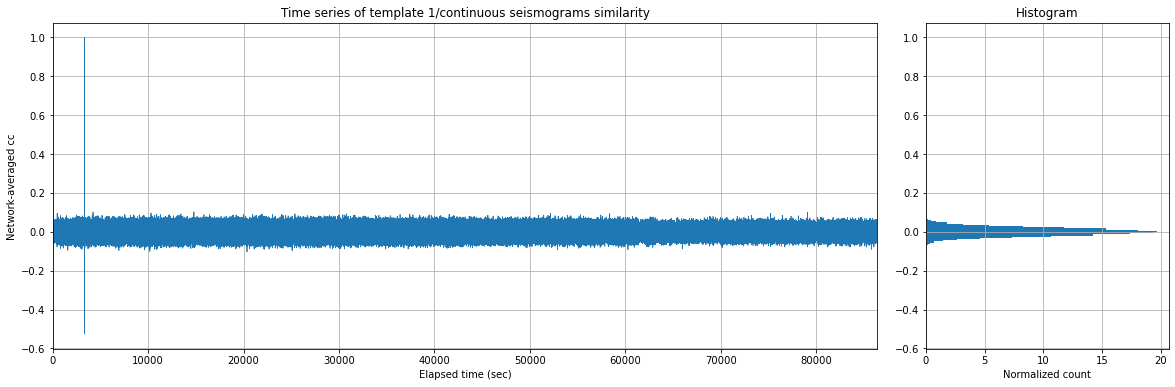

In [522]:
# let's print the output of our template matching run, which a time series of network-averaged correlation coefficients
# of same duration as the continuous seismograms
template_idx = 1
_cc = cc[template_idx, :]
time_cc = np.arange(len(_cc)) / SAMPLING_RATE_HZ

fig = plt.figure("network_averaged_cc", figsize=(20, 6))
gs = fig.add_gridspec(ncols=4)

ax1 = fig.add_subplot(gs[:3])
ax1.plot(time_cc, _cc, lw=0.75)
ax1.set_xlabel("Elapsed time (sec)")
ax1.set_ylabel("Network-averaged cc")
ax1.set_xlim(time_cc.min(), time_cc.max())
ax1.set_title(f"Time series of template {template_idx:d}/continuous seismograms similarity")

ax2 = fig.add_subplot(gs[3], sharey=ax1)
_ = ax2.hist(_cc, orientation="horizontal", bins=250, density=True)
ax2.set_xlabel("Normalized count")
ax2.set_title("Histogram")

for ax in [ax1, ax2]:
    ax.grid()


### Set detection threshold and find events

We will use the time series of correlation coefficients to build an earthquake catalog. For that, we need to set a detection threshold and define all times above that threshold as triggers caused by near-repeats of the template event.

In [523]:
def select_cc_indexes(
    cc_t,
    threshold,
    search_win,
):
    """Select the peaks in the CC time series.

    Parameters
    ------------
    cc_t: (n_corr,) numpy.ndarray
        The CC time series for one template.
    threshold: (n_corr,) numpy.ndarray or scalar
        The detection threshold.
    search_win: scalar int
        The minimum inter-event time, in units of correlation step.


    Returns
    --------
    cc_idx: (n_detections,) numpy.ndarray
        The list of all selected CC indexes. They give the timings of the
        detected events.
    """

    cc_detections = cc_t > threshold
    cc_idx = np.where(cc_detections)[0]

    cc_idx = list(cc_idx)
    n_rm = 0
    for i in range(1, len(cc_idx)):
        if (cc_idx[i - n_rm] - cc_idx[i - n_rm - 1]) < search_win:
            if cc_t[cc_idx[i - n_rm]] > cc_t[cc_idx[i - n_rm - 1]]:
                # keep (i-n_rm)-th detection
                cc_idx.remove(cc_idx[i - n_rm - 1])
            else:
                # keep (i-n_rm-1)-th detection
                cc_idx.remove(cc_idx[i - n_rm])
            n_rm += 1
    cc_idx = np.asarray(cc_idx)
    return cc_idx
    

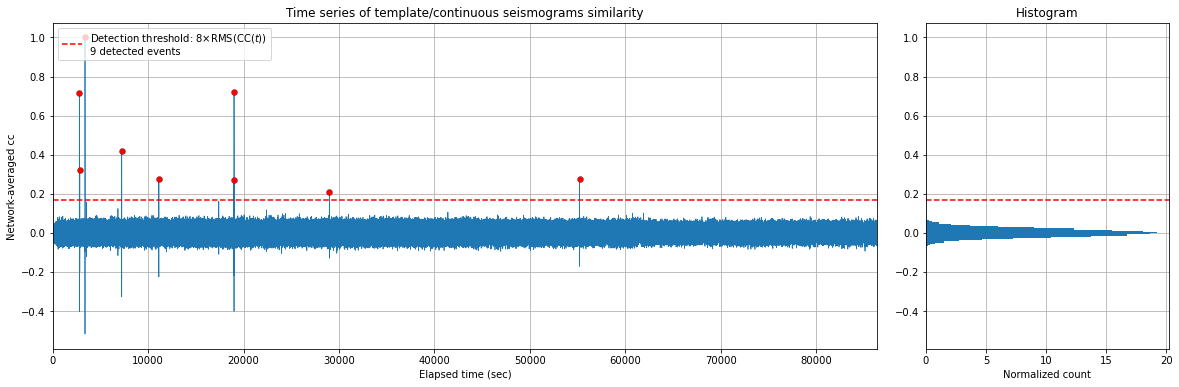

In [524]:
# INTEREVENT_TIME_RESOLUTION_SEC: In some cases, a template might trigger multiple, closely spaced detections because
#                                 of a phenomenon similar to that of "cycle skipping", where the waveform correlates
#                                 well with a time-shifted version of itself. Thus, to avoid redundant detections, we
#                                 set a minimum time separation between triggers (rule of thumb: about half the template duration)
INTEREVENT_TIME_RESOLUTION_SEC = 5.
INTEREVENT_TIME_RESOLUTION_SAMP = int(INTEREVENT_TIME_RESOLUTION_SEC * SAMPLING_RATE_HZ)
template_idx = 2
_cc = cc[template_idx, :]
time_cc = np.arange(len(_cc)) * FMF_STEP_SAMP / SAMPLING_RATE_HZ
NUM_RMS = 8.
detection_threshold = NUM_RMS * np.std(_cc)
event_cc_indexes = select_cc_indexes(_cc, detection_threshold, INTEREVENT_TIME_RESOLUTION_SAMP)

fig = plt.figure("network_averaged_cc", figsize=(20, 6))
gs = fig.add_gridspec(ncols=4)

ax1 = fig.add_subplot(gs[:3])
ax1.plot(time_cc, _cc, lw=0.75)
ax1.scatter(time_cc[event_cc_indexes], _cc[event_cc_indexes], linewidths=0.25, edgecolor="k", color="r", zorder=2)
ax1.set_xlabel("Elapsed time (sec)")
ax1.set_ylabel("Network-averaged cc")
ax1.set_xlim(time_cc.min(), time_cc.max())
ax1.set_title("Time series of template/continuous seismograms similarity")

ax2 = fig.add_subplot(gs[3], sharey=ax1)
_ = ax2.hist(_cc, orientation="horizontal", bins=250, density=True, zorder=2)
ax2.set_xlabel("Normalized count")
ax2.set_title("Histogram")

label = f"Detection threshold: {NUM_RMS:.0f}"r"$\times \mathrm{RMS}(\mathrm{CC}(t))$"f"\n{len(event_cc_indexes):d} detected events"
for ax in [ax1, ax2]:
    ax.grid()
    ax.axhline(
        detection_threshold, ls="--", color="r",
        label=label
        )
ax1.legend(loc="upper left")

### Assemble all detections to build the template matching catalog

Use the trigger times to build the earthquake catalog and extract event waveforms on a given station/component.

In [525]:
NUM_RMS = 8.
date = pd.Timestamp(
    (continuous_seismograms[0].stats.starttime.timestamp + continuous_seismograms[0].stats.endtime.timestamp) / 2.,
    unit="s"
).strftime("%Y-%m-%d")

catalog = {
    "detection_time": [],
    "cc": [],
    "normalized_cc": [],
    "tid": [],
    "longitude": [],
    "latitude": [],
    "depth": []
}

for t, tid in enumerate(template_ids):
    detection_threshold = NUM_RMS * np.std(cc[t, :])
    event_cc_indexes = select_cc_indexes(cc[t, :], detection_threshold, INTEREVENT_TIME_RESOLUTION_SAMP)
    for i in range(len(event_cc_indexes)):
        # --------------------------------------
        catalog["detection_time"].append(pd.Timestamp(date) + pd.Timedelta(event_cc_indexes[i] * FMF_STEP_SAMP / SAMPLING_RATE_HZ, "s"))
        catalog["cc"].append(cc[t, event_cc_indexes[i]])
        catalog["normalized_cc"].append(cc[t, event_cc_indexes[i]] / detection_threshold)
        catalog["tid"].append(tid)
        template_hypocenter = selected_events_meta[
            selected_events_meta["event_index"] == tid
        ].iloc[0]
        catalog["longitude"].append(template_hypocenter["longitude"])
        catalog["latitude"].append(template_hypocenter["latitude"])
        catalog["depth"].append(template_hypocenter["depth_km"])
catalog = pd.DataFrame(catalog)
catalog.sort_values("detection_time", inplace=True)
catalog

,detection_time,cc,normalized_cc,tid,longitude,latitude,depth
0,2019-07-04 00:46:45.640,1.000000,5.208949,6720,-117.882570,36.091088,4.643969
19,2019-07-04 00:46:45.640,0.339081,1.628305,17868,-117.866468,36.093520,4.981447
41,2019-07-04 00:46:45.640,0.629913,3.102449,13098,-117.879256,36.090409,4.268292
10,2019-07-04 00:46:45.640,0.716178,4.297031,5411,-117.880902,36.091986,4.854336
26,2019-07-04 00:46:45.680,0.276461,1.259135,25037,-117.846320,36.100386,5.943363
...,...,...,...,...,...,...,...
2959,2019-07-04 23:59:16.880,0.273072,1.869327,783,-117.471812,35.711704,8.944759
7531,2019-07-04 23:59:22.160,0.191812,1.316138,381,-117.501536,35.715034,11.589107
7194,2019-07-04 23:59:31.640,0.193527,1.305970,127,-117.515593,35.703031,10.744590
8293,2019-07-04 23:59:31.720,0.232111,1.578737,12050,-117.517267,35.702664,11.127555


### Plot some waveforms

When building a catalog, it is **always** necessary to visualize some of the detected event waveforms to get a sense of the ratio of true-to-false detection rate.

In the following, we plot the waveforms of each detected event and we also compare the stack of all the waveforms to the original template waveform. Since all events share similar waveforms, the stack is similar to the template waveform. Moreover, since noise across all these waveforms sums up incoherently, stacking acts as a denoiser which may help you produce a cleaner version of the template waveform, for example on remote stations.

In [526]:
STATION_NAME = "CLC"
COMPONENT_NAME = "Z"

sta_idx = station_codes.index(STATION_NAME)
cp_idx = component_codes.index(COMPONENT_NAME)
tp_idx = 223

subcatalog = catalog[catalog["tid"] == template_ids.iloc[tp_idx]]

detected_event_waveforms = []
for i in range(len(subcatalog)):
    detection_time_samp = (
        subcatalog["detection_time"].iloc[i] - pd.Timestamp(date)
    ).total_seconds() * SAMPLING_RATE_HZ
    idx_start = int(detection_time_samp) + moveouts_samp_arr[tp_idx, sta_idx, cp_idx]
    idx_end = idx_start + TEMPLATE_DURATION_SAMP
    detected_event_waveforms.append(continuous_seismograms_arr[sta_idx, cp_idx, idx_start:idx_end])

detected_event_waveforms = np.asarray(detected_event_waveforms)
detected_event_waveforms.shape

(17, 200)

Text(0, 0.5, 'Normalized amplitude')

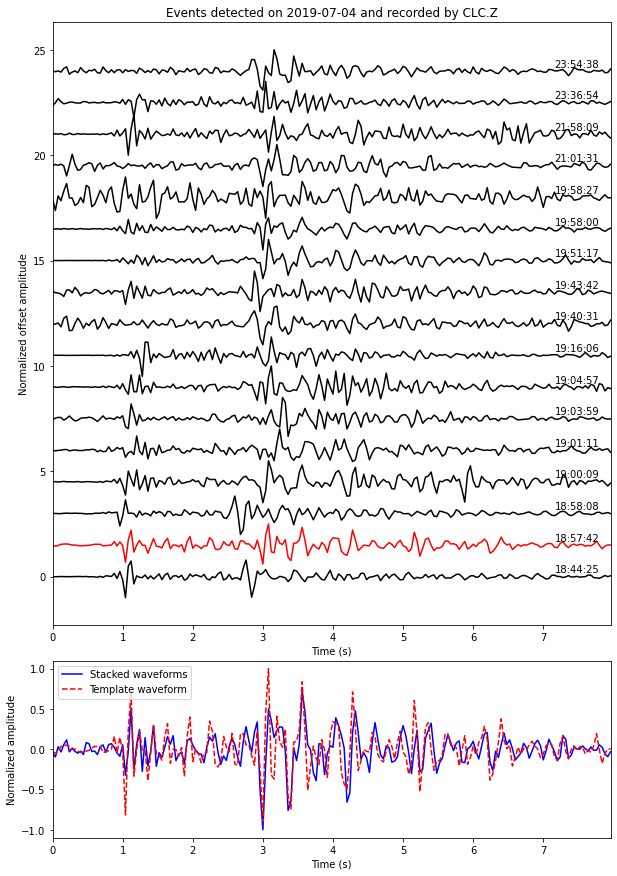

In [527]:
fig = plt.figure("detected_event_waveforms", figsize=(10, 15))
gs = fig.add_gridspec(nrows=4)

ax1 = fig.add_subplot(gs[:3])

_time_wav = np.arange(detected_event_waveforms.shape[1]) / SAMPLING_RATE_HZ

stack = np.zeros(detected_event_waveforms.shape[1])
for i in range(detected_event_waveforms.shape[0]):
    norm = np.abs(detected_event_waveforms[i, :]).max()
    if subcatalog["cc"].iloc[i] > 0.999:
        color = "r"
        template_wav = detected_event_waveforms[i, :] / norm
    else:
        color = "k"
    time_of_day = subcatalog["detection_time"].iloc[i].strftime("%H:%M:%S")
    ax1.plot(_time_wav, detected_event_waveforms[i, :] / norm + i * 1.5, color=color)
    ax1.text(0.98 * _time_wav.max(), i * 1.5 + 0.1, time_of_day, ha="right", va="bottom")
    stack += detected_event_waveforms[i, :] / norm
stack /= np.abs(stack).max()
ax1.set_xlabel("Time (s)")
ax1.set_xlim(_time_wav.min(), _time_wav.max())
ax1.set_ylabel("Normalized offset amplitude")
ax1.set_title(f"Events detected on {date} and recorded by {STATION_NAME}.{COMPONENT_NAME}")

ax2 = fig.add_subplot(gs[3], sharex=ax1)
ax2.plot(_time_wav, stack, color="blue", label="Stacked waveforms")
ax2.plot(_time_wav, template_wav, color="red", ls="--", label="Template waveform")
ax2.legend(loc="upper left")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Normalized amplitude")

## Plot inter-event time and template return time vs detection time

Having multiple templates, we can define two types of inter-event times:
- inter-event time: this is the time between two consecutive events in the catalog, disregarding their locations,
- return time: this is the time between two consecutive events detected by a same template, that is, two consecutive co-located events.

We naively assembled all the detected events from all the templates, but closely located templates can detect the same events, leading to multiple detections in the catalog. These multiples are visible with horizontal lines in the inter-event time vs detection time plot (see below).

In [528]:
catalog["interevent_time_s"] = catalog["detection_time"].diff().dt.total_seconds()
for tid in template_ids:
    subcatalog = catalog[catalog["tid"] == tid]
    catalog.loc[subcatalog.index, "return_time_s"] = subcatalog["detection_time"].diff().dt.total_seconds()
catalog

,detection_time,cc,normalized_cc,tid,longitude,latitude,depth,interevent_time_s,return_time_s
0,2019-07-04 00:46:45.640,1.000000,5.208949,6720,-117.882570,36.091088,4.643969,NaN,NaN
19,2019-07-04 00:46:45.640,0.339081,1.628305,17868,-117.866468,36.093520,4.981447,0.00,NaN
41,2019-07-04 00:46:45.640,0.629913,3.102449,13098,-117.879256,36.090409,4.268292,0.00,NaN
10,2019-07-04 00:46:45.640,0.716178,4.297031,5411,-117.880902,36.091986,4.854336,0.00,NaN
26,2019-07-04 00:46:45.680,0.276461,1.259135,25037,-117.846320,36.100386,5.943363,0.04,NaN
...,...,...,...,...,...,...,...,...,...
2959,2019-07-04 23:59:16.880,0.273072,1.869327,783,-117.471812,35.711704,8.944759,4.72,3658.12
7531,2019-07-04 23:59:22.160,0.191812,1.316138,381,-117.501536,35.715034,11.589107,5.28,4977.76
7194,2019-07-04 23:59:31.640,0.193527,1.305970,127,-117.515593,35.703031,10.744590,9.48,3191.20
8293,2019-07-04 23:59:31.720,0.232111,1.578737,12050,-117.517267,35.702664,11.127555,0.08,231.72


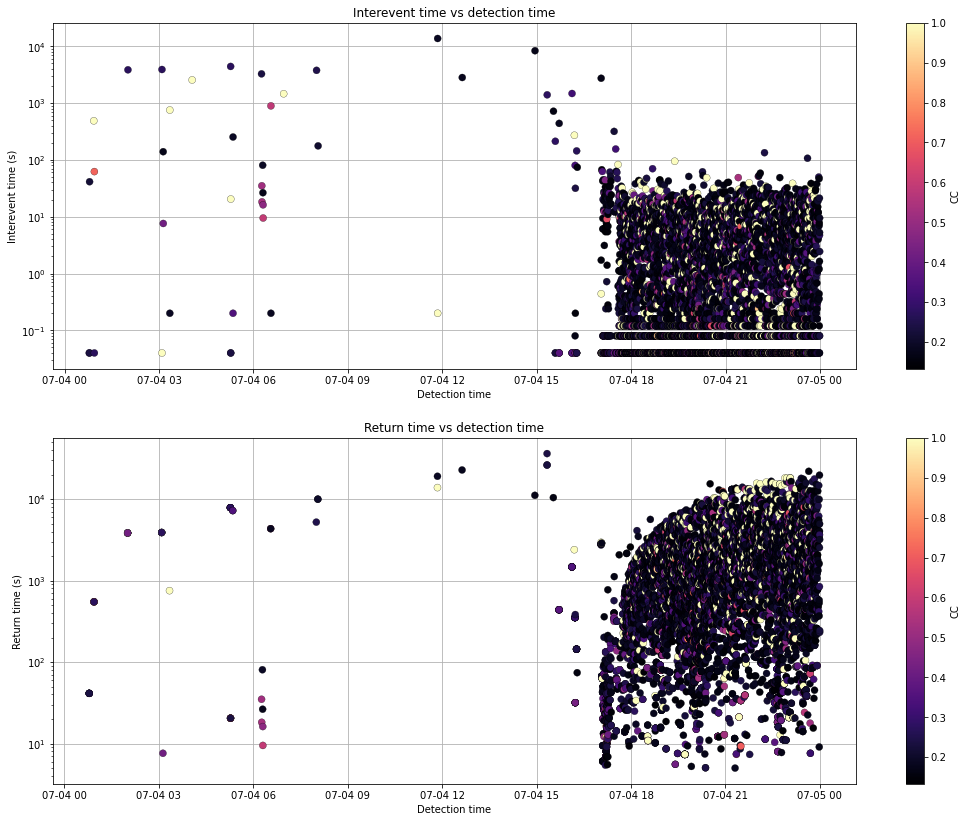

In [529]:
fig, axes = plt.subplots(num="interevent_time_vs_detection_time", nrows=2, figsize=(18, 14))

axes[0].scatter(
    catalog["detection_time"], catalog["interevent_time_s"], c=catalog["cc"],
    linewidths=0.25, edgecolor="k", cmap="magma", s=50, zorder=2
    )
axes[0].set_xlabel("Detection time")
axes[0].set_ylabel("Interevent time (s)")
axes[0].set_title("Interevent time vs detection time")

axes[1].scatter(
    catalog["detection_time"], catalog["return_time_s"], c=catalog["cc"],
    linewidths=0.25, edgecolor="k", cmap="magma", s=50, zorder=2
    )
axes[1].set_xlabel("Detection time")
axes[1].set_ylabel("Return time (s)")
axes[1].set_title("Return time vs detection time")

for ax in axes:
    ax.grid()
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label("CC")
    ax.set_yscale("log")

## "De-lumping" the catalog

Templates with similar waveforms and similar moveouts detect similar events. Thus, naively assembling the detected events from all templates results in "lumped" detections that represent multiple detections of the same event. (note: we avoid using "clustered" detections because the term "cluster" has lots of meaning in statistical seismology).

In the following, we:
- compute inter-template distances,
- compute inter-template waveform similarity (correlation coefficient),
- flag the "lumped" detections based on three criteria on inter-event time, inter-event distance and inter-event waveform similarity.

### Inter-template distances

In [ ]:
def compute_distances(
    source_longitudes,
    source_latitudes,
    source_depths,
    receiver_longitudes,
    receiver_latitudes,
    receiver_depths,
    backend="obspy"
):
    """
    Fast distance computation between all source points and all receivers.

    This function uses `cartopy.geodesic.Geodesic` to compute pair-wise distances
    between source points and receivers. It computes both hypocentral distances
    and, if specified, epicentral distances.

    Parameters
    ----------
    source_longitudes : numpy.ndarray or list
        Longitudes, in decimal degrees, of the source points.
    source_latitudes : numpy.ndarray or list
        Latitudes, in decimal degrees, of the source points.
    source_depths : numpy.ndarray or list
        Depths, in kilometers, of the source points.
    receiver_longitudes : numpy.ndarray or list
        Longitudes, in decimal degrees, of the receivers.
    receiver_latitudes : numpy.ndarray or list
        Latitudes, in decimal degrees, of the receivers.
    receiver_depths : numpy.ndarray or list
        Depths, in kilometers, of the receivers. Negative depths indicate
        receivers located at the surface.

    Returns
    -------
    hypocentral_distances : numpy.ndarray
        Array of hypocentral distances between source points and receivers.
        The shape of the array is (n_sources, n_receivers).
    """
    if backend == "cartopy":
        from cartopy.geodesic import Geodesic
    elif backend == "obspy":
        from obspy.geodetics.base import calc_vincenty_inverse
        
    source_longitudes = np.atleast_1d(source_longitudes)
    source_latitudes = np.atleast_1d(source_latitudes)
    source_depths = np.atleast_1d(source_depths)
    receiver_longitudes = np.atleast_1d(receiver_longitudes)
    receiver_latitudes = np.atleast_1d(receiver_latitudes)
    receiver_depths = np.atleast_1d(receiver_depths)

    # initialize distance array
    hypocentral_distances = np.zeros(
        (len(source_latitudes), len(receiver_latitudes)), dtype=np.float32
    )
    epicentral_distances = np.zeros(
        (len(source_latitudes), len(receiver_latitudes)), dtype=np.float32
    )
    if backend == "cartopy":
        # initialize the Geodesic instance
        G = Geodesic()
        for s in range(len(receiver_latitudes)):
            epi_distances = G.inverse(
                np.array([[receiver_longitudes[s], receiver_latitudes[s]]]),
                np.hstack(
                    (source_longitudes[:, np.newaxis], source_latitudes[:, np.newaxis])
                ),
            )
            epicentral_distances[:, s] = np.asarray(epi_distances)[:, 0].squeeze() / 1000.0
            hypocentral_distances[:, s] = np.sqrt(
                epicentral_distances[:, s] ** 2 + (source_depths - receiver_depths[s]) ** 2
            )
    elif backend == "obspy":
        for s1 in range(len(source_latitudes)):
            for s2 in range(len(receiver_latitudes)):
                dist, _, _ = calc_vincenty_inverse(
                    source_latitudes[s1],
                    source_longitudes[s1],
                    receiver_latitudes[s2],
                    receiver_longitudes[s2],
                )
                epicentral_distances[s1, s2] = dist / 1000.0
                hypocentral_distances[s1, s2] = np.sqrt(
                    epicentral_distances[s1, s2] ** 2 + (source_depths[s1] - receiver_depths[s2]) ** 2
                )
    return hypocentral_distances

In [531]:
intertemplate_distances = compute_distances(
    selected_events_meta["longitude"].values,
    selected_events_meta["latitude"].values,
    selected_events_meta["depth_km"].values,
    selected_events_meta["longitude"].values,
    selected_events_meta["latitude"].values, 
    selected_events_meta["depth_km"].values,
    backend="obspy"
)

intertemplate_distances = pd.DataFrame(
        index=template_ids.values, columns=template_ids.values, data=intertemplate_distances
    )

intertemplate_distances

,6720,17122,5411,17868,25037,6929,7607,13098,15698,4380,...,3733,11897,910,341,5934,9083,13305,6293,10909,6747
6720,0.000000,79.720917,0.277062,1.513100,3.661949,19.026287,11.666162,0.485678,2.143338,19.266460,...,28.748285,61.275852,52.038624,59.792736,58.538982,47.874050,49.704773,50.195679,57.541214,56.467831
17122,79.720917,0.000000,79.789001,79.838013,80.411301,82.627167,71.581108,79.649605,78.469719,83.105278,...,56.714146,31.158018,45.438164,34.562592,33.451321,48.411022,45.710072,46.708466,45.250542,42.855175
5411,0.277062,79.789001,0.000000,1.317072,3.428295,18.851551,11.727011,0.629307,1.981982,19.088093,...,28.712433,61.289993,52.007412,59.782089,58.536476,47.875999,49.678215,50.149368,57.499794,56.440426
17868,1.513100,79.838013,1.317072,0.000000,2.190433,17.535700,11.202190,1.397858,1.630720,17.772236,...,28.115082,60.881992,51.348293,59.303776,58.096458,47.229881,49.035213,49.474678,56.810215,55.807220
25037,3.661949,80.411301,3.428295,2.190433,0.000000,15.621014,11.494502,3.581764,2.825583,15.833551,...,27.726255,60.813461,50.848087,59.064812,57.931202,46.883896,48.574974,48.897926,56.227928,55.343788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9083,47.874050,48.411022,47.875999,47.229881,46.883896,41.692081,36.861530,47.601456,46.348061,42.128132,...,20.998363,19.081427,9.226923,18.280758,17.826046,0.000000,7.776943,11.396736,14.017366,12.323303
13305,49.704773,45.710072,49.678215,49.035213,48.574974,43.554199,39.517002,49.493969,47.980606,43.960644,...,21.178249,15.883133,2.486704,13.015112,12.991101,7.776943,0.000000,3.934742,8.345553,6.825695
6293,50.195679,46.708466,50.149368,49.474678,48.897926,43.544212,40.496021,50.010254,48.375713,43.923611,...,21.549055,17.343016,3.761866,13.325891,13.700439,11.396736,3.934742,0.000000,7.611817,7.308194
10909,57.541214,45.250542,57.499794,56.810215,56.227928,50.198162,47.537022,57.339027,55.753185,50.565315,...,28.959011,14.759328,5.861502,10.763541,12.184548,14.017366,8.345553,7.611817,0.000000,3.275540


In [532]:
intertemplate_distances = compute_distances(
    selected_events_meta["longitude"].values,
    selected_events_meta["latitude"].values,
    selected_events_meta["depth_km"].values,
    selected_events_meta["longitude"].values,
    selected_events_meta["latitude"].values, 
    selected_events_meta["depth_km"].values,
    backend="cartopy"
)

intertemplate_distances = pd.DataFrame(
        index=template_ids.values, columns=template_ids.values, data=intertemplate_distances
    )

intertemplate_distances

,6720,17122,5411,17868,25037,6929,7607,13098,15698,4380,...,3733,11897,910,341,5934,9083,13305,6293,10909,6747
6720,0.000000,79.720917,0.277062,1.513100,3.661949,19.026285,11.666162,0.485678,2.143338,19.266460,...,28.748285,61.275852,52.038624,59.792736,58.538982,47.874050,49.704773,50.195683,57.541214,56.467831
17122,79.720917,0.000000,79.789001,79.838013,80.411301,82.627167,71.581108,79.649605,78.469719,83.105278,...,56.714146,31.158018,45.438164,34.562592,33.451321,48.411022,45.710072,46.708466,45.250542,42.855175
5411,0.277062,79.789001,0.000000,1.317072,3.428295,18.851551,11.727011,0.629307,1.981982,19.088093,...,28.712433,61.289993,52.007412,59.782089,58.536476,47.875999,49.678215,50.149368,57.499794,56.440426
17868,1.513100,79.838013,1.317072,0.000000,2.190433,17.535700,11.202190,1.397858,1.630720,17.772236,...,28.115082,60.881992,51.348293,59.303776,58.096458,47.229881,49.035213,49.474678,56.810215,55.807220
25037,3.661949,80.411301,3.428295,2.190433,0.000000,15.621014,11.494502,3.581764,2.825583,15.833551,...,27.726255,60.813461,50.848087,59.064812,57.931202,46.883900,48.574970,48.897926,56.227928,55.343788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9083,47.874050,48.411022,47.875999,47.229881,46.883900,41.692085,36.861530,47.601456,46.348061,42.128132,...,20.998363,19.081427,9.226923,18.280758,17.826046,0.000000,7.776943,11.396736,14.017366,12.323303
13305,49.704773,45.710072,49.678215,49.035213,48.574970,43.554199,39.517002,49.493969,47.980606,43.960644,...,21.178249,15.883133,2.486704,13.015112,12.991101,7.776943,0.000000,3.934742,8.345553,6.825695
6293,50.195683,46.708466,50.149368,49.474678,48.897926,43.544212,40.496021,50.010254,48.375717,43.923611,...,21.549055,17.343016,3.761866,13.325892,13.700439,11.396736,3.934742,0.000000,7.611817,7.308194
10909,57.541214,45.250542,57.499794,56.810215,56.227928,50.198162,47.537022,57.339027,55.753185,50.565315,...,28.959011,14.759328,5.861502,10.763542,12.184548,14.017366,8.345553,7.611817,0.000000,3.275540


### Inter-template waveform similarity

In [533]:
def compute_intertemplate_cc(
    template_waveforms_arr,
    max_lag=5,
):
    """
    Compute the pairwise template cross-correlations (CCs).

    Parameters
    ----------
    max_lag : int, default to 5
        The maximum lag, in samples, allowed when searching for the maximum
        CC on each channel. This parameter accounts for small discrepancies
        in windowing that could occur for two templates highly similar but
        associated with slightly different locations.
        reading a potentially large file.

    Returns
    -------
    intertemplate_cc : numpy.ndarray
        The computed inter-template correlation coefficients.
    """
    # format arrays for FMF
    data_arr = template_waveforms_arr.copy()
    template_arr = template_waveforms_arr[..., max_lag:-max_lag]
    moveouts_arr = np.zeros(template_waveforms_arr.shape[:-1], dtype=np.int32)
    num_templates = template_waveforms_arr.shape[0]
    intertp_cc = np.zeros(
        (num_templates, num_templates), dtype=np.float32
    )
    # use FMF on one template at a time against all others
    for t in range(num_templates):
        weights = np.ones(template_arr.shape[:-1], dtype=np.float32)
        for s in range(template_arr.shape[1]):
            for c in range(template_arr.shape[2]):
                if np.sum(template_arr[t, s, c, :]) == 0.:
                    weights[t, s, c] = 0.
        weights /= np.sum(weights, axis=(1, 2), keepdims=True)
        keep = np.sum(weights != 0.0, axis=(1, 2)) > 0
        cc = fmf.matched_filter(
            template_arr[keep, ...],
            moveouts_arr[keep, ...],
            weights[keep, ...],
            data_arr[t, ...],
            1,
            arch="cpu",
            network_sum=False,
            check_zeros=False,
        )
        intertp_cc[t, keep] = np.sum(
            weights[keep, ...] * np.max(cc, axis=1), axis=(-1, -2)
        )
    # make the CC matrix symmetric by averaging the lower
    # and upper triangles
    intertemplate_cc = (intertp_cc + intertp_cc.T) / 2.0
    return intertemplate_cc

In [534]:
intertemplate_cc = compute_intertemplate_cc(
    template_waveforms_arr.astype(np.float32),
)

intertemplate_cc = pd.DataFrame(
        index=template_ids.values, columns=template_ids.values, data=intertemplate_cc
    )

intertemplate_cc

,6720,17122,5411,17868,25037,6929,7607,13098,15698,4380,...,3733,11897,910,341,5934,9083,13305,6293,10909,6747
6720,1.000000,0.027428,0.248301,0.128720,0.119031,0.068705,0.075539,0.196440,0.097394,0.066785,...,0.064462,0.033454,0.030623,0.028775,0.030853,0.029237,0.033768,0.050524,0.047637,0.041777
17122,0.027428,1.000000,0.026761,0.026829,0.032013,0.024978,0.027899,0.025736,0.033046,0.024862,...,0.034811,0.065602,0.056293,0.059984,0.072702,0.045179,0.052081,0.050459,0.045123,0.051460
5411,0.248301,0.026761,1.000000,0.139320,0.110125,0.075083,0.072549,0.193988,0.095849,0.074843,...,0.070623,0.039743,0.033977,0.025233,0.034048,0.033736,0.033273,0.052135,0.052709,0.045557
17868,0.128720,0.026829,0.139320,1.000000,0.130679,0.056800,0.071021,0.148250,0.092264,0.071087,...,0.055197,0.030743,0.028529,0.020380,0.032241,0.030409,0.034576,0.043859,0.038458,0.029215
25037,0.119031,0.032013,0.110125,0.130679,1.000000,0.062907,0.069270,0.133696,0.102896,0.064461,...,0.053312,0.028509,0.036324,0.026229,0.027577,0.032606,0.033975,0.047996,0.037807,0.040282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9083,0.029237,0.045179,0.033736,0.030409,0.032606,0.037664,0.034719,0.033916,0.026739,0.049771,...,0.052088,0.074603,0.081570,0.078450,0.060359,1.000000,0.062585,0.057824,0.065711,0.062075
13305,0.033768,0.052081,0.033273,0.034576,0.033975,0.037316,0.027540,0.031308,0.034490,0.037897,...,0.053978,0.085699,0.073243,0.062671,0.073228,0.062585,1.000000,0.069554,0.082031,0.085256
6293,0.050524,0.050459,0.052135,0.043859,0.047996,0.051520,0.043395,0.048264,0.045893,0.059161,...,0.067654,0.086148,0.064724,0.076438,0.078336,0.057824,0.069554,1.000000,0.079080,0.071196
10909,0.047637,0.045123,0.052709,0.038458,0.037807,0.055493,0.049102,0.044462,0.046792,0.054465,...,0.072801,0.083891,0.083470,0.063200,0.072974,0.065711,0.082031,0.079080,1.000000,0.096372


### Flag multiples

In [535]:
def flag_multiples(
    catalog,
    intertemplate_distances,
    intertemplate_cc,
    dt_criterion=4.0,
    distance_criterion=15.,
    similarity_criterion=-1.0,
):
    """
    Search for events detected by multiple templates and flag them.

    Parameters
    ----------
    catalog : pd.DataFrame
    dt_criterion : float, optional
        The time interval, in seconds, under which two events are examined for redundancy.
    distance_criterion : float, optional
        The inter-event distance, in kilometers, under which two events are examined for redundancy.
    similarity_criterion : float, optional
        The template similarity threshold, in terms of average cc, over which two events
        are examined for redundancy. The default value of -1 means that similarity is not
        taken into account.
    intertemplate_cc : pd.DataFrame
    progress : bool, optional
        If True, print progress bar with `tqdm`.
    **kwargs
        Additional keyword arguments.

    Returns
    -------
    unique_event : numpy.ndarray
        A (`len(detection_times)`,) `numpy.ndarray` of booleans with `unique_event[i]=True`
        if event number `i` is a unique detection of a single event.
    """
    detection_time_sec = catalog["detection_time"].values.astype("datetime64[ms]").astype("float64") / 1000.
    interevent_time = np.hstack(
        ([1.10 * dt_criterion], detection_time_sec[1:] - detection_time_sec[:-1])
    )
    # -----------------------------------
    n_events = len(catalog)
    unique_event = np.ones(n_events, dtype=bool)
    for n1 in range(n_events):
        if not unique_event[n1]:
            # was already flagged as a multiple
            continue
        tid1 = catalog["tid"].iloc[n1]
        # apply the time criterion
        n2 = n1 + 1
        if n2 < n_events:
            dt_n1n2 = interevent_time[n2]
        else:
            continue
        temporal_neighbors = [n1]
        while dt_n1n2 < dt_criterion:
            temporal_neighbors.append(n2)
            n2 += 1
            if n2 >= n_events:
                break
            dt_n1n2 += interevent_time[n2]
        temporal_neighbors = np.array(temporal_neighbors).astype("int64")
        if len(temporal_neighbors) == 1:
            # did not find any temporal neighbors
            continue
        # remove events that were already flagged as non unique
        temporal_neighbors = temporal_neighbors[unique_event[temporal_neighbors]]
        candidates = temporal_neighbors
        if len(candidates) == 1:
            continue
        tids_candidates = catalog["tid"].values[temporal_neighbors]
        
        similarities = intertemplate_cc.loc[tid1, tids_candidates].values
        
        distances = intertemplate_distances.loc[tid1, tids_candidates].values
        
        multiples = candidates[
            np.where(
                (similarities >= similarity_criterion)
                & (distances <= distance_criterion)
                )[0]
        ]
        unique_event[multiples] = False
        # find best CC and keep it
        ccs = catalog["cc"].values[multiples]
        best_cc = multiples[ccs.argmax()]
        unique_event[best_cc] = True
    # -------------------------------------------
    return unique_event

In [556]:
SIMILARITY_CRITERION = 0.1
DT_CRITERION = INTEREVENT_TIME_RESOLUTION_SEC # re-use same time resolution as before
DISTANCE_CRITERION = 15.0

# if the inter-template cc value is below this value, and there are two or more detections that are close in time to each other, these will NOT be flagged as multiples. 
# So they *might* be discrete events... We need to do some tests to see how sensitive the catalog looks to this parameter ?  
unique_event = flag_multiples(
    catalog,
    intertemplate_distances,
    intertemplate_cc,
    dt_criterion=DT_CRITERION,
    similarity_criterion=SIMILARITY_CRITERION,
    distance_criterion=DISTANCE_CRITERION,
)

catalog["unique_event"] = unique_event

catalog

,detection_time,cc,normalized_cc,tid,longitude,latitude,depth,interevent_time_s,return_time_s,unique_event,m_rel,detection_time_sec
0,2019-07-04 00:46:45.640,1.000000,5.208949,6720,-117.882570,36.091088,4.643969,NaN,NaN,True,0.595368,1.562201e+09
19,2019-07-04 00:46:45.640,0.339081,1.628305,17868,-117.866468,36.093520,4.981447,0.00,NaN,False,0.302823,1.562201e+09
41,2019-07-04 00:46:45.640,0.629913,3.102449,13098,-117.879256,36.090409,4.268292,0.00,NaN,False,0.632657,1.562201e+09
10,2019-07-04 00:46:45.640,0.716178,4.297031,5411,-117.880902,36.091986,4.854336,0.00,NaN,False,0.674579,1.562201e+09
26,2019-07-04 00:46:45.680,0.276461,1.259135,25037,-117.846320,36.100386,5.943363,0.04,NaN,False,0.349690,1.562201e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
2959,2019-07-04 23:59:16.880,0.273072,1.869327,783,-117.471812,35.711704,8.944759,4.72,3658.12,True,-0.915777,1.562285e+09
7531,2019-07-04 23:59:22.160,0.191812,1.316138,381,-117.501536,35.715034,11.589107,5.28,4977.76,True,-0.774148,1.562285e+09
7194,2019-07-04 23:59:31.640,0.193527,1.305970,127,-117.515593,35.703031,10.744590,9.48,3191.20,False,-1.156079,1.562285e+09
8293,2019-07-04 23:59:31.720,0.232111,1.578737,12050,-117.517267,35.702664,11.127555,0.08,231.72,True,-1.250340,1.562285e+09


In [557]:
catalog[catalog["unique_event"]]

,detection_time,cc,normalized_cc,tid,longitude,latitude,depth,interevent_time_s,return_time_s,unique_event,m_rel,detection_time_sec
0,2019-07-04 00:46:45.640,1.000000,5.208949,6720,-117.882570,36.091088,4.643969,NaN,NaN,True,0.595368,1.562201e+09
11,2019-07-04 00:47:26.920,0.320361,1.922152,5411,-117.880902,36.091986,4.854336,0.00,41.28,True,0.346957,1.562201e+09
9,2019-07-04 00:55:33.360,1.000000,6.145690,17122,-117.799226,35.378160,11.078458,486.40,NaN,True,1.142510,1.562202e+09
12,2019-07-04 00:56:35.560,1.000000,5.999952,5411,-117.880902,36.091986,4.854336,0.00,548.64,True,0.912494,1.562202e+09
22,2019-07-04 02:00:37.440,1.000000,4.802108,17868,-117.866468,36.093520,4.981447,0.00,3841.88,True,0.209530,1.562206e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
1608,2019-07-04 23:59:12.160,0.167771,1.122184,8143,-117.536542,35.732510,10.353954,0.04,19694.52,True,-0.810293,1.562285e+09
2959,2019-07-04 23:59:16.880,0.273072,1.869327,783,-117.471812,35.711704,8.944759,4.72,3658.12,True,-0.915777,1.562285e+09
7531,2019-07-04 23:59:22.160,0.191812,1.316138,381,-117.501536,35.715034,11.589107,5.28,4977.76,True,-0.774148,1.562285e+09
8293,2019-07-04 23:59:31.720,0.232111,1.578737,12050,-117.517267,35.702664,11.127555,0.08,231.72,True,-1.250340,1.562285e+09


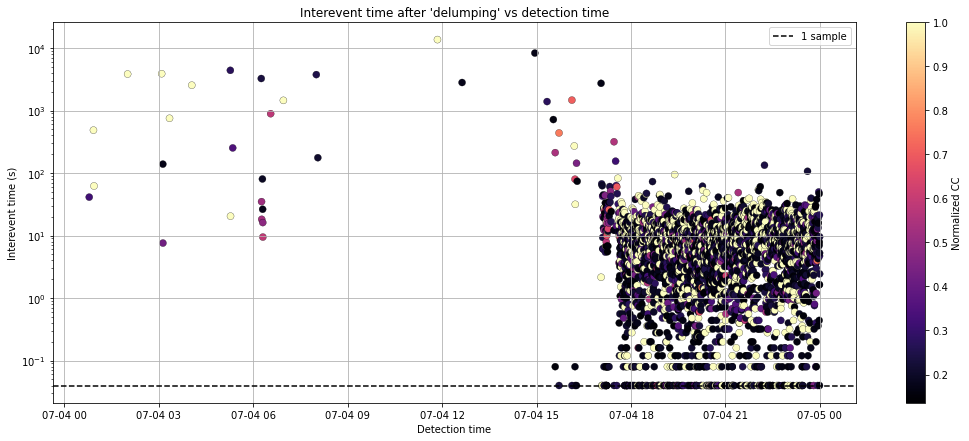

In [558]:
cat_delumped = catalog[catalog["unique_event"]]
interevent_times_delumped_cat = cat_delumped["detection_time"].diff().dt.total_seconds()

fig, ax = plt.subplots(num="interevent_time_vs_detection_time", figsize=(18, 7))

ax.scatter(cat_delumped["detection_time"], interevent_times_delumped_cat, c=cat_delumped["cc"], linewidths=0.25, edgecolor="k", cmap="magma", s=50)
ax.axhline(1. / SAMPLING_RATE_HZ, ls="--", color="k", label="1 sample")
ax.set_xlabel("Detection time")
ax.set_ylabel("Interevent time (s)")
ax.set_title("Interevent time after 'delumping' vs detection time")

ax.grid()
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label("Normalized CC")
ax.set_yscale("log")
ax.legend(loc="upper right")

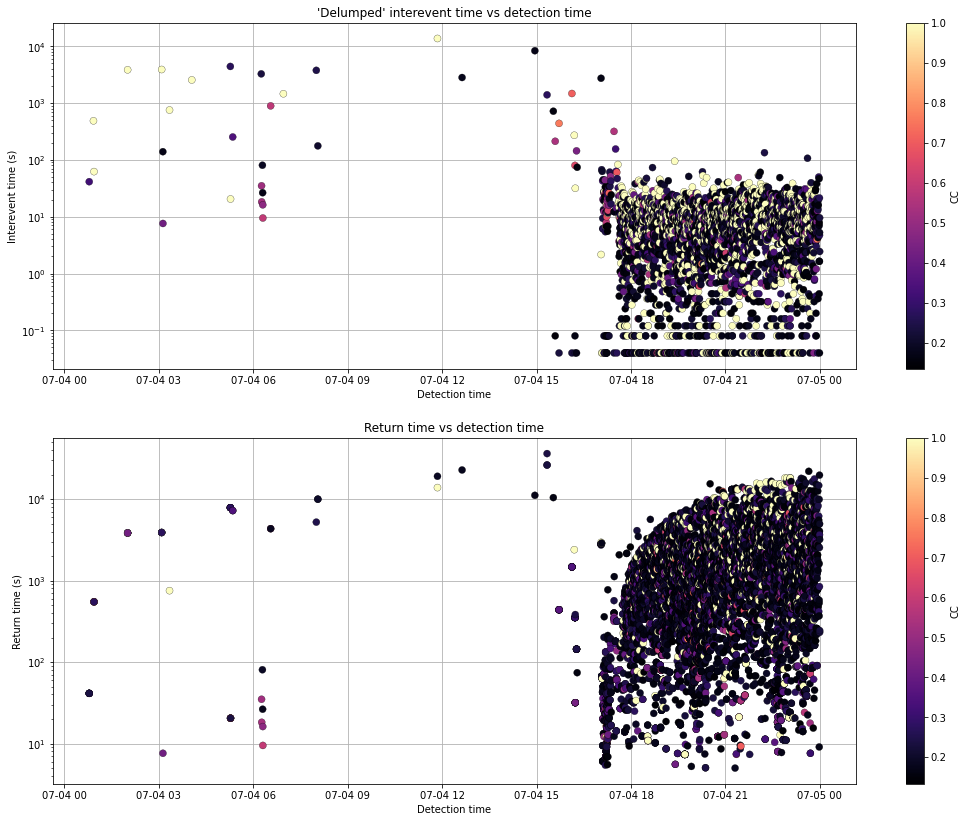

In [559]:
cat_delumped = catalog[catalog["unique_event"]]
interevent_times_delumped_cat = cat_delumped["detection_time"].diff().dt.total_seconds()

fig, axes = plt.subplots(num="delumped_interevent_time_vs_detection_time", nrows=2, figsize=(18, 14))

axes[0].scatter(
    cat_delumped["detection_time"], interevent_times_delumped_cat, c=cat_delumped["cc"],
    linewidths=0.25, edgecolor="k", cmap="magma", s=50, zorder=2
    )
axes[0].set_xlabel("Detection time")
axes[0].set_ylabel("Interevent time (s)")
axes[0].set_title("'Delumped' interevent time vs detection time")

axes[1].scatter(
    catalog["detection_time"], catalog["return_time_s"], c=catalog["cc"],
    linewidths=0.25, edgecolor="k", cmap="magma", s=50, zorder=2
    )
axes[1].set_xlabel("Detection time")
axes[1].set_ylabel("Return time (s)")
axes[1].set_title("Return time vs detection time")

for ax in axes:
    ax.grid()
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label("CC")
    ax.set_yscale("log")

Note how the plots of inter-event times and return times differ even after "delumping" the catalog. In the process of delumping, we make arbitrary choices (see the criteria above) and we end up discarding some real events and keeping some repeats of the same event. Thus, some valuable information may be lost in the process. The pre-delumping catalog should always be kept because some studies may be well-suited for a template-by-template analysis, or may not be negatively affected by the presence of redundant detections, thus making optimal use of the template matching catalog.

## Relative magnitudes

In [560]:
# first, extract clips from the continuous seismograms
detected_event_waveforms_all_channels = np.zeros(
    (len(catalog), num_stations, num_channels, TEMPLATE_DURATION_SAMP), dtype=np.float32
)
for i in range(len(catalog)):
    tid = catalog["tid"].iloc[i]
    t =template_ids.tolist().index(tid)
    for s in range(num_stations):
        for c in range(num_channels):
            if moveouts_samp_arr[t, s, c] < 0:
                continue
            detection_time_samp = (
                catalog["detection_time"].iloc[i] - pd.Timestamp(date)
            ).total_seconds() * SAMPLING_RATE_HZ
            idx_start = int(detection_time_samp) * FMF_STEP_SAMP + moveouts_samp_arr[t, s, c]
            idx_end = idx_start + TEMPLATE_DURATION_SAMP
            detected_event_waveforms_all_channels[i, s, c, :] = (
                continuous_seismograms_arr[s, c, idx_start:idx_end]
                )


In [561]:
m_rel = np.zeros(len(catalog), dtype=np.float32)

# then, measure the peak amplitudes and apply the above formula to get the relative magnitudes
peak_amplitudes = np.max(np.abs(detected_event_waveforms_all_channels), axis=-1)

for tid in catalog["tid"].unique():
    t = selected_events_meta["event_index"].tolist().index(tid)
    m_ref = selected_events_meta["magnitude"].iloc[t]
    ref_event_index = np.where(
        (catalog["tid"] == tid) & (catalog["cc"]> 0.99)
    )[0][0]
    peak_amplitudes_ref = peak_amplitudes[ref_event_index, ...]
    template_subcat = catalog[catalog["tid"] == tid]
    
    amplitude_ratios = peak_amplitudes[catalog["tid"] == tid, ...] / peak_amplitudes_ref
    invalid = (np.isnan(amplitude_ratios) | np.isinf(amplitude_ratios))
    amplitude_ratios = np.ma.masked_where(invalid, amplitude_ratios)
    
    catalog.loc[template_subcat.index, "m_rel"] = (
        m_ref + np.ma.mean(np.log10(amplitude_ratios), axis=(1, 2))
    )
catalog

/tmp/ipykernel_471471/1462564979.py:15: RuntimeWarning: invalid value encountered in true_divide
  amplitude_ratios = peak_amplitudes[catalog["tid"] == tid, ...] / peak_amplitudes_ref


,detection_time,cc,normalized_cc,tid,longitude,latitude,depth,interevent_time_s,return_time_s,unique_event,m_rel,detection_time_sec
0,2019-07-04 00:46:45.640,1.000000,5.208949,6720,-117.882570,36.091088,4.643969,NaN,NaN,True,0.595368,1.562201e+09
19,2019-07-04 00:46:45.640,0.339081,1.628305,17868,-117.866468,36.093520,4.981447,0.00,NaN,False,0.302823,1.562201e+09
41,2019-07-04 00:46:45.640,0.629913,3.102449,13098,-117.879256,36.090409,4.268292,0.00,NaN,False,0.632657,1.562201e+09
10,2019-07-04 00:46:45.640,0.716178,4.297031,5411,-117.880902,36.091986,4.854336,0.00,NaN,False,0.674579,1.562201e+09
26,2019-07-04 00:46:45.680,0.276461,1.259135,25037,-117.846320,36.100386,5.943363,0.04,NaN,False,0.349690,1.562201e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
2959,2019-07-04 23:59:16.880,0.273072,1.869327,783,-117.471812,35.711704,8.944759,4.72,3658.12,True,-0.915777,1.562285e+09
7531,2019-07-04 23:59:22.160,0.191812,1.316138,381,-117.501536,35.715034,11.589107,5.28,4977.76,True,-0.774148,1.562285e+09
7194,2019-07-04 23:59:31.640,0.193527,1.305970,127,-117.515593,35.703031,10.744590,9.48,3191.20,False,-1.156079,1.562285e+09
8293,2019-07-04 23:59:31.720,0.232111,1.578737,12050,-117.517267,35.702664,11.127555,0.08,231.72,True,-1.250340,1.562285e+09


Next, we plot the distribution of earthquake magnitudes. The cumulative distribution usually follows the so-called Gutenberg-Richter law:
$$ \log N(m \geq M) = a - b M$$

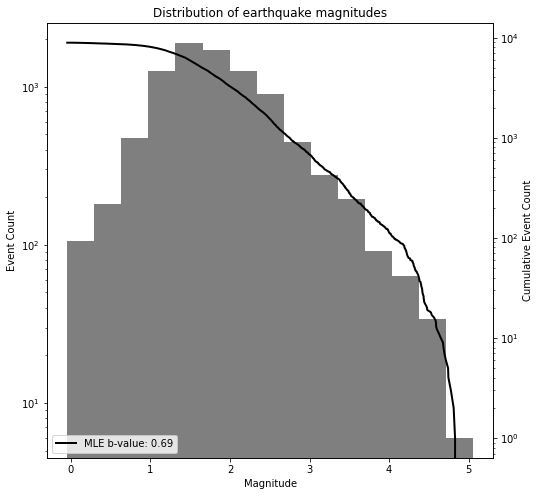

In [573]:
fig, ax = plt.subplots(num="magnitude_distribution", figsize=(8, 8))
axb = ax.twinx()
ax.set_title("Distribution of earthquake magnitudes")

# cut off the last events of the day because those are in the tapered part of the continuous seismograms
_cat = catalog[catalog["detection_time"] < "2019-07-04T23:45:00"]

count, m_bins, _ = ax.hist(_cat["m_rel"], bins=15, color="k", alpha=0.5, label="All channels")

# calculate the b-value
m_midbins = 0.5 * (m_bins[:-1] + m_bins[1:])
# estimate the magnitude of completeness with the maximum curvature method (Mc is taken as the mode of the magnitude distribution)
m_c = m_midbins[count.argmax()]
m_above_Mc = _cat["m_rel"][_cat["m_rel"] > m_c].values
m_c_w_buffer = m_c + 0.1
# estimate the b-value with the maximum likelihood method
bvalue = 1.0 / (np.log(10) * np.mean(m_above_Mc - m_c_w_buffer))

axb.plot(np.sort(_cat["m_rel"]), np.arange(len(_cat))[::-1], color="k", lw=2, label=f"MLE b-value: {bvalue:.2f}")

ax.set_xlabel("Magnitude")
ax.set_ylabel("Event Count")
axb.set_ylabel("Cumulative Event Count")
axb.legend(loc="lower left")

for ax in [ax, axb]:
    ax.set_yscale("log")

Note: the physical meaning of the b-value is better understood when the Gutenberg-Richter law is recast in terms of a power-law of the seismic moment, $M_0$. Assuming we have the following scaling relationship between magnitude and seismic moment: $M \sim c \log M_0$, then:
$$ \log N \sim b c \log M_0 \Leftrightarrow N \sim M_0^{bc}.$$
The value of the exponent $bc$ is fixed by the physical properties of the system. Thus, it is clear that the b-value depends on the choice of the magnitude scale.

Moreover, one must keep in mind that such a scaling relationship, $M \sim c \log M_0$, may not hold over the entire magnitude range. Moment magnitudes, $M_w$, were introduced to make sure that magnitudes and seismic moments were related through a unique scaling relationship for any magnitudes, but the relative magnitudes used here hardly ensure such a consistent scaling. Relative magnitudes, therefore, should not be used for thorough analyses of the b-value (and things like time variations of the b-value).

## Compare with deep learning catalog

In [563]:
deep_learning_cat = event_meta[
    (event_meta["time"] > "2019-07-04")
    & (event_meta["time"] < "2019-07-05")
].copy()
deep_learning_cat["time"] = pd.to_datetime(deep_learning_cat["time"])
deep_learning_cat

,time,adloc_score,adloc_residual_time,num_picks,magnitude,adloc_residual_amplitude,event_index,longitude,latitude,depth_km
0,2019-07-04 00:46:47.342963596,0.866596,0.057355,35,0.595368,0.165480,6720,-117.882570,36.091088,4.643969
1,2019-07-04 00:55:32.648412579,0.781116,0.203567,16,1.142510,0.170509,17122,-117.799226,35.378160,11.078458
2,2019-07-04 00:56:37.232733104,0.908073,0.086183,42,0.912494,0.166681,5411,-117.880902,36.091986,4.854336
3,2019-07-04 02:00:39.149363202,0.814322,0.036164,15,0.209530,0.092534,17868,-117.866468,36.093520,4.981447
4,2019-07-04 03:05:31.018885833,0.799281,0.080708,11,0.104050,0.156833,25037,-117.846320,36.100386,5.943363
...,...,...,...,...,...,...,...,...,...,...
978,2019-07-04 23:57:57.991578467,0.860503,0.046175,18,0.884022,0.134415,13748,-117.593034,35.768763,8.755313
979,2019-07-04 23:58:33.755557349,0.841734,0.253947,43,1.213073,0.123163,8383,-117.549675,35.741730,2.446929
980,2019-07-04 23:58:48.057018725,0.878082,0.039899,65,1.410004,0.082498,2445,-117.509182,35.716748,10.672514
981,2019-07-04 23:59:20.859908653,0.675912,0.025560,27,1.293314,0.124839,21156,-117.504724,35.713536,11.309137


In [564]:
deep_learning_cat["time_sec"] = (
    deep_learning_cat["time"].values.astype("datetime64[ms]").astype("float64") / 1000.
)
catalog["detection_time_sec"] = (
    catalog["detection_time"].values.astype("datetime64[ms]").astype("float64") / 1000.
)

In [565]:
# find SCSN events in the BPMF catalog
MAX_ORIGIN_TIME_DIFFERENCE_SEC = 5.
MAX_DISTANCE_KM = 15.
VELOCITY_MS = 3500.

cat_u = catalog[catalog["unique_event"]]

matching_event_id = np.zeros(len(deep_learning_cat), dtype=object)
unmatched = np.ones(len(cat_u), dtype=bool)
for i in range(len(deep_learning_cat)):
    delta_t = np.abs(deep_learning_cat.iloc[i]["time_sec"] - cat_u["detection_time_sec"].values)
    time_neighbors = (delta_t <= MAX_ORIGIN_TIME_DIFFERENCE_SEC) & unmatched
    if np.sum(time_neighbors) == 0:
        continue
    time_neighbors = np.where(time_neighbors)[0]
    distance = np.zeros(len(time_neighbors), dtype=np.float32)
    for j in range(len(time_neighbors)):
        distance[j] = compute_distances(
            deep_learning_cat.iloc[i]["longitude"],
            deep_learning_cat.iloc[i]["latitude"],
            0.,
            cat_u.iloc[time_neighbors[j]]["longitude"],
            cat_u.iloc[time_neighbors[j]]["latitude"],
            0.,
        )
    space_neighbors = distance <= MAX_DISTANCE_KM
    if np.sum(space_neighbors) == 0:
        continue
    # restrict distances to subset of space and time neighbors
    distance = distance[space_neighbors]
    # get indexes of BPMF catalog corresponding to space-time neighbors
    space_neighbors = time_neighbors[space_neighbors]
    if len(space_neighbors) == 1:
        matching_event_id[i] = cat_u.index[space_neighbors[0]]
        unmatched[space_neighbors[0]] = False
    else:
        space_time_distance = np.zeros(len(space_neighbors), dtype=np.float32)
        for k in range(len(space_neighbors)):
            space_time_distance[k] = (
                delta_t[space_neighbors[k]] + distance[k] / VELOCITY_MS
            )
        matching_event_id[i] = cat_u.index[space_neighbors[space_time_distance.argmin()]]
        unmatched[space_neighbors[space_time_distance.argmin()]] = False
num_matched_events = np.sum(matching_event_id != 0.)
num_unmatched_events = len(deep_learning_cat) - num_matched_events
matched_pct = 100. * (float(num_matched_events) / len(deep_learning_cat))
print(f"{num_matched_events:d} events ({matched_pct:.2f}%) of the deep learning catalog were matched with the template matching catalog.")
    

972 events (98.88%) of the deep learning catalog were matched with the template matching catalog.


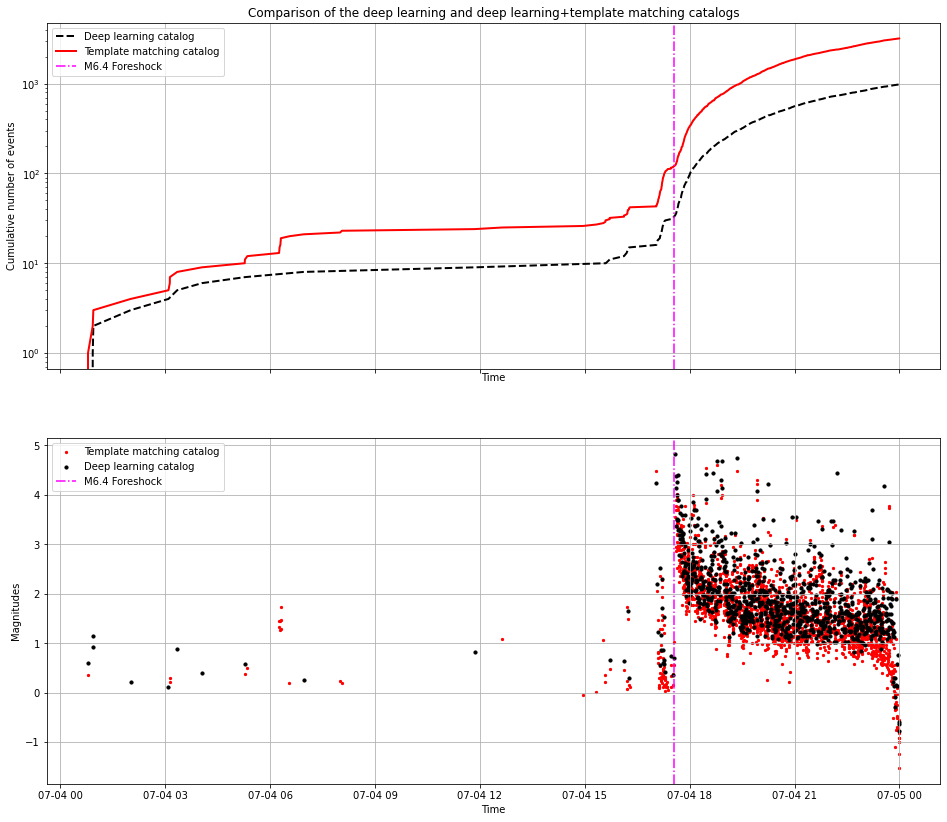

In [571]:
M64_FORESHOCK_TIME = pd.Timestamp("2019-07-04T17:34:00")

fig, axes = plt.subplots(num="catalog_comparison", nrows=2, figsize=(16, 14), sharex=True)

axes[0].plot(deep_learning_cat["time"], np.arange(len(deep_learning_cat)), color="k", ls="--", lw=2, label="Deep learning catalog")
axes[0].plot(cat_u["detection_time"], np.arange(len(cat_u)), color="r", lw=2, label="Template matching catalog")
axes[0].set_yscale("log")
axes[0].set_ylabel("Cumulative number of events")
axes[0].set_title("Comparison of the deep learning and deep learning+template matching catalogs")


in_both_cats = np.isin(cat_u.index, matching_event_id)
axes[1].scatter(
    cat_u.loc[~in_both_cats, "detection_time"], cat_u.loc[~in_both_cats, "m_rel"], color="r", s=5, marker="o", rasterized=True, label="Template matching catalog"
)
axes[1].scatter(
    cat_u.loc[in_both_cats, "detection_time"], cat_u.loc[in_both_cats, "m_rel"], color="k", s=10, marker="o", rasterized=True,  label="Deep learning catalog"
)
axes[1].set_ylabel("Magnitudes")

for ax in axes:
    ax.axvline(
        M64_FORESHOCK_TIME, color="magenta", ls="-.",
        label="M6.4 Foreshock"
    )
    ax.grid()
    ax.set_xlabel("Time")
    ax.legend(loc="upper left")

NOTE: The magnitudes computed after the M6.4 foreshock are likely to be highly affected by the overall elevated noise level and the coda waves of previous events. The comparison mostly shows that the deep learning+template matching catalog adds events that were too small to be detected by deep learning, but template matching also does better at times of intense seismicity when phase association is difficult.

In [567]:
def fetch_detected_event_waveforms(detecton_time, moveouts):
    event_waveforms = np.zeros(
        (num_stations, num_channels, TEMPLATE_DURATION_SAMP), dtype=np.float32
    )
    for s in range(num_stations):
        for c in range(num_channels):
            detection_time_samp = (
                detecton_time - pd.Timestamp(date)
            ).total_seconds() * SAMPLING_RATE_HZ
            idx_start = int(detection_time_samp) + max(0, moveouts[s, c])
            idx_end = idx_start + TEMPLATE_DURATION_SAMP
            event_waveforms[s, c, :] = (
                continuous_seismograms_arr[s, c, idx_start:idx_end]
                )
    return event_waveforms

In [568]:
new_events_cat = cat_u[~in_both_cats].copy()
new_events_cat

,detection_time,cc,normalized_cc,tid,longitude,latitude,depth,interevent_time_s,return_time_s,unique_event,m_rel,detection_time_sec
11,2019-07-04 00:47:26.920,0.320361,1.922152,5411,-117.880902,36.091986,4.854336,0.00,41.28,True,0.346957,1.562201e+09
33,2019-07-04 03:07:48.640,0.172434,1.150105,6929,-117.673684,36.114308,5.894466,139.20,NaN,True,0.217015,1.562210e+09
34,2019-07-04 03:07:56.240,0.419868,2.800440,6929,-117.673684,36.114308,5.894466,7.60,7.60,True,0.295035,1.562210e+09
46,2019-07-04 05:16:24.960,0.273424,1.346671,13098,-117.879256,36.090409,4.268292,4406.12,7855.56,True,0.376857,1.562217e+09
51,2019-07-04 05:20:58.200,0.349437,2.165419,4380,-117.671909,36.118573,6.085804,0.20,7228.80,True,0.487145,1.562218e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
1520,2019-07-04 23:59:12.120,0.157782,1.072620,19614,-117.559906,35.713991,8.982811,1.64,4049.80,True,-0.776425,1.562285e+09
1608,2019-07-04 23:59:12.160,0.167771,1.122184,8143,-117.536542,35.732510,10.353954,0.04,19694.52,True,-0.810293,1.562285e+09
2959,2019-07-04 23:59:16.880,0.273072,1.869327,783,-117.471812,35.711704,8.944759,4.72,3658.12,True,-0.915777,1.562285e+09
8293,2019-07-04 23:59:31.720,0.232111,1.578737,12050,-117.517267,35.702664,11.127555,0.08,231.72,True,-1.250340,1.562285e+09


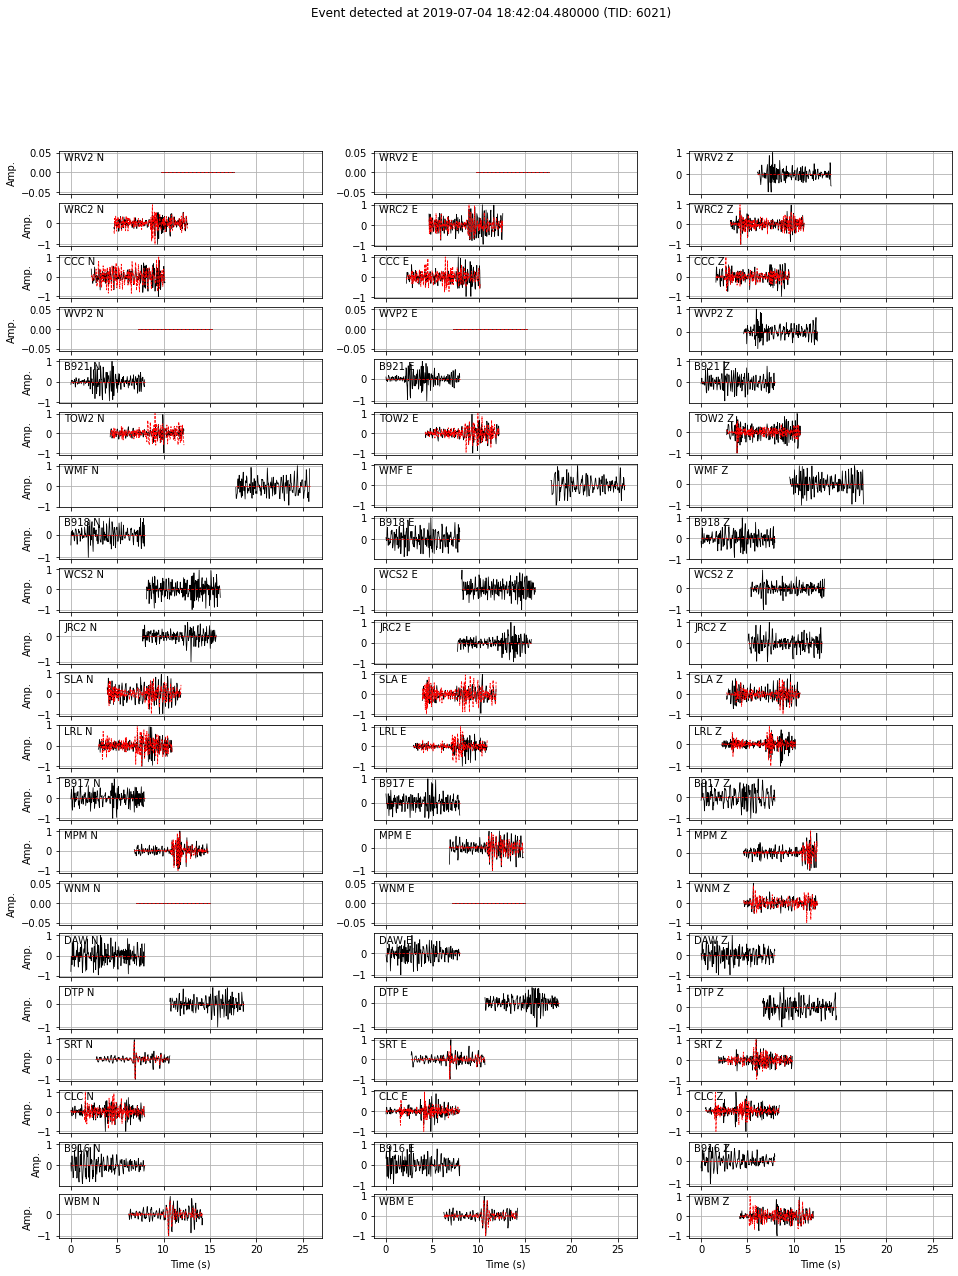

In [569]:
evidx = 456
tid = new_events_cat["tid"].iloc[evidx]
tidx = template_ids.tolist().index(tid)

event_waveforms = fetch_detected_event_waveforms(
    new_events_cat["detection_time"].iloc[evidx],
    moveouts_samp_arr[tidx]
)

def _max_norm(x):
    norm = np.abs(x).max()
    if norm == 0.:
        return x
    return x / norm

fig, axes = plt.subplots(num="event_waveforms", nrows=num_stations, ncols=num_channels, figsize=(16, 20), sharex=True)
fig.suptitle(f"Event detected at {new_events_cat['detection_time'].iloc[evidx]} (TID: {tid})")
for s, sta in enumerate(station_codes):
    for c, cp in enumerate(component_codes):
        time_sec = (max(0., moveouts_samp_arr[tidx, s, c]) + np.arange(TEMPLATE_DURATION_SAMP)) / SAMPLING_RATE_HZ
        axes[s, c].plot(
            time_sec,
            _max_norm(event_waveforms[s, c, :]),
            color="k",
            lw=0.75
        )
        axes[s, c].plot(
            time_sec,
            _max_norm(template_waveforms_arr[tidx, s, c, :]),
            color="r",
            lw=0.75,
            ls="--",
        )
        axes[s, c].text(0.02, 0.96, sta + " " + cp, ha="left", va="top", transform=axes[s, c].transAxes)
        # axes[s, c].set_title(sta + " " + cp)
        if s == num_stations - 1:
            axes[s, c].set_xlabel("Time (s)")
        if c == 0:
            axes[s, c].set_ylabel("Amp.")
        axes[s, c].grid()
# plt.tight_layout()